# Loan approval prediction

#### This project discusses on building an optimum machine learning model to determine if an individual will be approved for a bank loan
#### 1) Features determining the loan status are personal details, educational & employment details
#### 2) Main aim will be to get the best possible classification accuracy

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv("loan_train.csv")
test = pd.read_csv("loan_test.csv")

In [86]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [5]:
x = train.drop("Loan_Status", axis=1)
y = train["Loan_Status"]

In [6]:
# Categorisation of features

cat_col = x.select_dtypes("object").columns
num_col = x.select_dtypes(["int64","float64"]).columns

In [7]:
# Missing value treatment -> Numerical data

print(train[num_col].isnull().sum())

null_num_col = train[num_col].isnull().sum()[train[num_col].isnull().sum()!=0].index.tolist()

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
dtype: int64


In [8]:
for nul_col in null_num_col:
    print(nul_col)
    print(train[nul_col].value_counts(), "\n")
    print("Unique values:", train[nul_col].nunique())
    print("=============================================")

LoanAmount
120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: LoanAmount, Length: 203, dtype: int64 

Unique values: 203
Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64 

Unique values: 10
Credit_History
1.0    475
0.0     89
Name: Credit_History, dtype: int64 

Unique values: 2


In [9]:
# Fill the missing values of credit history using 

# from sklearn.impute import SimpleImputer

# temp_df = train[num_col]

# imputer1 = SimpleImputer(strategy='most_frequent')
# imputed_values1 = imputer1.fit_transform(temp_df)

# train1 = pd.DataFrame(imputed_values1, columns=train[num_col].columns)
# train1.head()

In [13]:
# Based on the above understanding, use KNN to fill the null values in 'Loan_Amount_Term' & 'Credit_History'

import pandas as pd
from sklearn.impute import KNNImputer

num_col = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

knn_imputer = KNNImputer(n_neighbors=1, weights='uniform')

unique_loan_term_values = train['Loan_Amount_Term'].dropna().unique()
unique_credit_history_values = train['Credit_History'].dropna().unique()

knn_imputer.categorical_values_ = {
    'Loan_Amount_Term': unique_loan_term_values,
    'Credit_History': unique_credit_history_values
}

imputed_data = knn_imputer.fit_transform(train[num_col])

train2= pd.DataFrame(imputed_data, columns=num_col)
train.Loan_Amount_Term = train2.Loan_Amount_Term
train.Credit_History = train2.Credit_History

In [14]:
train[num_col].isnull().sum()

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History        0
dtype: int64

In [15]:
# Missing value treatment -> Categorical data

train[cat_col].isnull().sum()

Loan_ID           0
Gender           13
Married           3
Dependents       15
Education         0
Self_Employed    32
Property_Area     0
dtype: int64

In [16]:
train[cat_col].head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,LP001002,Male,No,0,Graduate,No,Urban
1,LP001003,Male,Yes,1,Graduate,No,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,Urban
4,LP001008,Male,No,0,Graduate,No,Urban


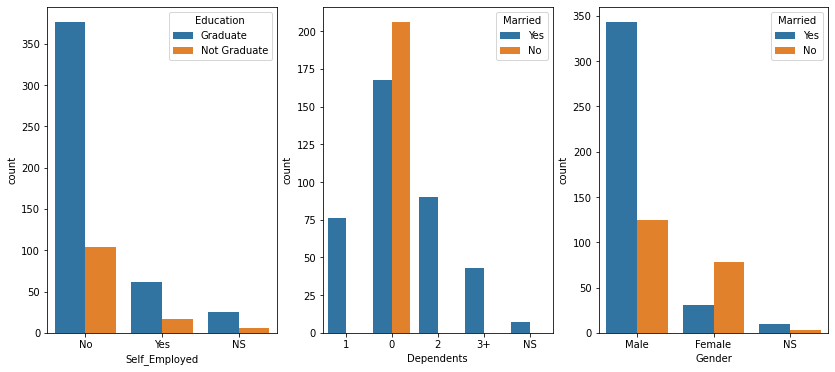

In [59]:
fig,axes = plt.subplots(1,3,figsize=(14,6))

sns.countplot(x='Self_Employed', hue='Education',data=train[cat_col], ax=axes[0])
sns.countplot(x='Dependents', hue='Married',data=train[cat_col], ax=axes[1])
sns.countplot(x='Gender', hue='Married',data=train[cat_col], ax=axes[2])
plt.show()

In [18]:
# Inferences that can be drawn from the above plots to fill the most obvious missing values
# 1) If Married='No' then, Dependents=0

train.loc[train['Married'] == 'No', 'Dependents'] = '0'

In [19]:
# Drop rows where both Married & Dependents are null

drop_rows = train[train['Dependents'].isnull() & train['Married'].isnull()].index.tolist()
train.drop(drop_rows, inplace=True)

In [20]:
train[cat_col] = train[cat_col].fillna(value='NS')
train.dropna(subset=['LoanAmount'], inplace=True)

In [21]:
# Divide into features & target. Split the data

x = train.drop(["Loan_Status","Loan_ID"], axis=1)
y = train['Loan_Status']

cat_cols = x.select_dtypes("object").columns.tolist()
cat_dummies = pd.get_dummies(x[cat_cols])

x_new = pd.concat([x,cat_dummies], axis=1)
x_new.drop(cat_cols, axis=1, inplace=True)

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y = le.fit_transform(y)

In [38]:
# Splitting the data

from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x_new,y, test_size=0.3, stratify=y, random_state=42)

## Model building

#### Model 1 -> Building a pipleline to determine the best base model

In [39]:
# Build pipeline

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [40]:
pipelines = {
    "XGB": make_pipeline(xgb.XGBClassifier(objective="binary:logistic")),
    "LR": make_pipeline(LogisticRegression(max_iter=1000)),
    "RF": make_pipeline(RandomForestClassifier())
}

In [44]:
hyper_para = {
    "XGB": {
        'xgbclassifier__scale_pos_weight': [0.45,1,2.25],
        'xgbclassifier__eta': [0.01, 0.1, 0.5],
        # 'xgbclassifier__booster': ['gbtree', 'gblinear'],
        'xgbclassifier__max_depth': [3,4,5],
        'xgbclassifier__n_estimators': [100,200,500]
    },
    "LR": {
        'logisticregression__C': [0.1,1,10],
        'logisticregression__class_weight': [None, 'balanced']
    },
    "RF": {
        'randomforestclassifier__n_estimators': [100,200,500],
        'randomforestclassifier__max_depth': [3,4,5],
        'randomforestclassifier__criterion': ['entropy','gini']
    }
}

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

fit_models = {}

for algo, pipline in pipelines.items():
    model = GridSearchCV(pipline, hyper_para[algo], cv=3, scoring='f1')
    try:
        print("Started training for {}".format(algo))
        model.fit(xtrain, ytrain)
        best_para = model.best_params_
        fit_models[algo] = model
        print("{} has been fit".format(algo))
        print("Best params for", algo, "=", best_para)
    except NotFittedError as e:
        print(repr(e))

Started training for XGB
XGB has been fit
Best params for XGB = {'xgbclassifier__eta': 0.01, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__scale_pos_weight': 2.25}
Started training for LR
LR has been fit
Best params for LR = {'logisticregression__C': 1, 'logisticregression__class_weight': None}
Started training for RF
RF has been fit
Best params for RF = {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 100}


In [53]:
# Validating the model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

for algo,model in fit_models.items():
    best_model = model.best_estimator_
    ypred = best_model.predict(xtest)
    print("{} accuracy score: {}".format(algo, accuracy_score(ytest, ypred)))
    print(confusion_matrix(ypred,ytest))
    print("===========================================")

XGB accuracy score: 0.8135593220338984
[[ 23   2]
 [ 31 121]]
LR accuracy score: 0.807909604519774
[[ 24   4]
 [ 30 119]]
RF accuracy score: 0.807909604519774
[[ 23   3]
 [ 31 120]]


In [48]:
best_xgb = fit_models['XGB'].best_estimator_
best_lr = fit_models['LR'].best_estimator_
best_rf = fit_models['RF'].best_estimator_

#### Determining the feature importances from each model

In [49]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler((0.1,1))

xgb = XGBClassifier(objective="binary:logistic", eta=0.1, n_estimators=300, scale_pos_weight=2.25, booster='gblinear', random_state=42)
xgb.fit(xtrain,ytrain)
lr = LogisticRegression(C=1, class_weight=None, random_state=42)
lr.fit(xtrain,ytrain)
rfc = RandomForestClassifier(criterion='gini', n_estimators=200, max_depth=4, random_state=42)
rfc.fit(xtrain,ytrain)

xgb_imp = pd.DataFrame(dict(xgb=xgb.feature_importances_), index=xgb.feature_names_in_)
rfc_imp = pd.DataFrame(dict(rfc=rfc.feature_importances_), index=lr.feature_names_in_)

importances = pd.concat([xgb_imp,rfc_imp], axis=1)
importances['cross'] = min_max.fit_transform(importances[['xgb']])* min_max.fit_transform(importances[['rfc']])
sorted_feat = importances.sort_values(by='cross', ascending=False).reset_index()
sorted_feat

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,index,xgb,rfc,cross
0,Credit_History,2.127483,0.419926,1.000000
1,LoanAmount,-0.002378,0.119053,0.073979
2,ApplicantIncome,0.000012,0.106323,0.068442
3,CoapplicantIncome,-0.000028,0.072139,0.052738
4,Property_Area_Semiurban,0.230578,0.031488,0.047758
5,Loan_Amount_Term,-0.001120,0.048539,0.041820
6,Married_Yes,0.102283,0.018708,0.033227
7,Education_Graduate,0.089208,0.017983,0.032200
8,Education_Not Graduate,0.000450,0.016706,0.027303
9,Gender_NS,0.066083,0.008289,0.026113


In [76]:
# Based on the above observation, none of the features have feature importance so low as to drop them

#### Model 2-> Resampling the data to balance w.r.t target feature

In [56]:
# Resampling the data to balance the target feature

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
xsmote, ysmote = smote.fit_resample(x_new,y)

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
xrus, yrus = rus.fit_resample(x_new,y)

In [60]:
import xgboost as xgb
from xgboost import XGBClassifier

model1 = xgb.XGBClassifier(objective="binary:logistic", eta=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2.25 )
model1.fit(xsmote, ysmote)
# model1.fit(xrus,yrus)

ypred1 = model1.predict(xtest)
print("Accuracy:",accuracy_score(ytest,ypred1))
print(confusion_matrix(ytest,ypred1))

Accuracy: 0.8192090395480226
[[ 24  30]
 [  2 121]]


#### Model 3 -> Voting classifier

In [77]:
# Voting classifier

from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

xgb = xgb.XGBClassifier(objective="binary:logistic", eta=0.01, max_depth=3, n_estimators=200, scale_pos_weight=2.25, random_state=42 )
lr = LogisticRegression(C=1, class_weight=None, random_state=42)
rfc = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=4, random_state=42)

voting = VotingClassifier(estimators=[('xgb',xgb),('lr',lr),('rfc',rfc)], voting='hard')

In [68]:
voting.fit(xtrain,ytrain)
ypred2 = voting.predict(xtest)

print(confusion_matrix(ytest,ypred2))
print(accuracy_score(ytest,ypred2))

[[ 23  31]
 [  2 121]]
0.8135593220338984


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model 4 -> Bagging classifier

In [75]:
# Bagging classifier

from sklearn.ensemble import BaggingClassifier

xbg_new = fit_models['XGB'].best_estimator_
xgb_bag = BaggingClassifier(xbg_new, n_estimators=10, max_samples=0.8, random_state=42)
xgb_bag.fit(xtrain,ytrain)
ypred3 = voting.predict(xtest)

print(confusion_matrix(ytest,ypred3))
print(accuracy_score(ytest,ypred3))

[[ 23  31]
 [  2 121]]
0.8135593220338984


In [73]:
# Varying the threshold

pred_prob = pd.DataFrame(xgb_bag.predict_proba(xtest)[:,1])

thres = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.65, 0.7, 0.8, 0.9]

for i in thres:
    print("For threshold {}".format(i))
    ypred3 = pred_prob.applymap(lambda x:1 if x>i else 0)
    print(confusion_matrix(ytest,ypred3))
    print(accuracy_score(ytest,ypred3))
    print("===========================")

For threshold 0.1
[[  0  54]
 [  0 123]]
0.6949152542372882
For threshold 0.2
[[ 14  40]
 [  1 122]]
0.768361581920904
For threshold 0.3
[[ 22  32]
 [  2 121]]
0.807909604519774
For threshold 0.4
[[ 23  31]
 [  2 121]]
0.8135593220338984
For threshold 0.5
[[ 23  31]
 [  2 121]]
0.8135593220338984
For threshold 0.6
[[ 24  30]
 [  2 121]]
0.8192090395480226
For threshold 0.65
[[ 24  30]
 [  2 121]]
0.8192090395480226
For threshold 0.7
[[ 25  29]
 [  3 120]]
0.8192090395480226
For threshold 0.8
[[27 27]
 [27 96]]
0.6949152542372882
For threshold 0.9
[[ 54   0]
 [123   0]]
0.3050847457627119


In [84]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
acc_score = []

for train_index, test_index in cv.split(x_new,y):
    xtrain_fold, xtest_fold = x_new.iloc[train_index], x_new.iloc[test_index]
    ytrain_fold, ytest_fold = y[train_index], y[test_index]
    
    xgb_bag.fit(xtrain_fold, ytrain_fold)
    ypred = xgb_bag.predict(xtest_fold)
    
    pred_prob = pd.DataFrame(xgb_bag.predict_proba(xtest_fold)[:,1])
    ypred = pred_prob.applymap(lambda x:1 if x>0.6 else 0)
    
    print("Accuracy:", accuracy_score(ytest_fold, ypred))
    acc_score.append(accuracy_score(ytest_fold, ypred))
    print(confusion_matrix(ytest_fold, ypred))
    print("==============================")
    
print("Average accuracy score:", sum(acc_score)/len(acc_score))

Accuracy: 0.8192090395480226
[[ 24  30]
 [  2 121]]
Accuracy: 0.8305084745762712
[[ 27  27]
 [  3 120]]
Accuracy: 0.8305084745762712
[[ 28  26]
 [  4 119]]
Accuracy: 0.8361581920903954
[[ 25  29]
 [  0 123]]
Accuracy: 0.8192090395480226
[[ 22  32]
 [  0 123]]
Average accuracy score: 0.8271186440677966


#### Conclusion -> The best model is acheived by keeping the threshold b/w 0.6 and 0.7 (Avg accuracy = 82.7%)